# Ejercicio 1 - Descarga y exploración del corpus

### Importaciones

In [1]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from nltk import RegexpTokenizer
from collections import Counter
from stop_words import get_stop_words
from nltk import ngrams

from wordcloud import WordCloud
from num2words import num2words
from gensim.models import Word2Vec
from gensim.models import FastText
from gensim.models.word2vec import LineSentence
from nltk.stem import WordNetLemmatizer

from sklearn.manifold import TSNE


### Cargamos los datos

In [2]:
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Amazon_Instant_Video_5.json.gz
data_reviews = pd.read_json('reviews_Amazon_Instant_Video_5.json.gz', 
                            lines=True, compression='gzip')
data_reviews.head()

--2022-02-13 18:58:29--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Amazon_Instant_Video_5.json.gz
Resolviendo snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Conectando con snap.stanford.edu (snap.stanford.edu)[171.64.75.80]:80... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 9517526 (9,1M) [application/x-gzip]
Guardando como: “reviews_Amazon_Instant_Video_5.json.gz”

reviews_Amazon_Inst 100%[===================>]   9,08M   271KB/s    en 44s     

2022-02-13 18:59:14 (210 KB/s) - “reviews_Amazon_Instant_Video_5.json.gz” guardado [9517526/9517526]



,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A11N155CW1UV02,B000H00VBQ,AdrianaM,"[0, 0]",I had big expectations because I love English ...,2,A little bit boring for me,1399075200,"05 3, 2014"
1,A3BC8O2KCL29V2,B000H00VBQ,Carol T,"[0, 0]",I highly recommend this series. It is a must f...,5,Excellent Grown Up TV,1346630400,"09 3, 2012"
2,A60D5HQFOTSOM,B000H00VBQ,"Daniel Cooper ""dancoopermedia""","[0, 1]",This one is a real snoozer. Don't believe anyt...,1,Way too boring for me,1381881600,"10 16, 2013"
3,A1RJPIGRSNX4PW,B000H00VBQ,"J. Kaplan ""JJ""","[0, 0]",Mysteries are interesting. The tension betwee...,4,Robson Green is mesmerizing,1383091200,"10 30, 2013"
4,A16XRPF40679KG,B000H00VBQ,Michael Dobey,"[1, 1]","This show always is excellent, as far as briti...",5,Robson green and great writing,1234310400,"02 11, 2009"


In [3]:
print(f'Tenemos {data_reviews.shape[0]} con {data_reviews.shape[1]} columnas de información')
print(f'\nTipo de las columnas :\n{data_reviews.dtypes}')

Tenemos 37126 con 9 columnas de información

Tipo de las columnas :
reviewerID        object
asin              object
reviewerName      object
helpful           object
reviewText        object
overall            int64
summary           object
unixReviewTime     int64
reviewTime        object
dtype: object


In [4]:
data_reviews = data_reviews[['reviewerName', 'summary', 'reviewText', 'overall']]
print('Nos quedamos con las columnas importantes para nuestro análisis de sentimiento')
data_reviews.head()

Nos quedamos con las columnas importantes para nuestro análisis de sentimiento


,reviewerName,summary,reviewText,overall
0,AdrianaM,A little bit boring for me,I had big expectations because I love English ...,2
1,Carol T,Excellent Grown Up TV,I highly recommend this series. It is a must f...,5
2,"Daniel Cooper ""dancoopermedia""",Way too boring for me,This one is a real snoozer. Don't believe anyt...,1
3,"J. Kaplan ""JJ""",Robson Green is mesmerizing,Mysteries are interesting. The tension betwee...,4
4,Michael Dobey,Robson green and great writing,"This show always is excellent, as far as briti...",5


### Tokenización

In [5]:
# Esta función tokeniza, elimina signos de puntuación,lematiza y elimina StopWords
def list_to_words(text):
    words = []
    sw_list = get_stop_words('en')
    
    for sentence in text:
        
        for word in RegexpTokenizer(r"\w+").tokenize(sentence):            
            #w = RegexpTokenizer(r"\w+\'\w+|\w+").tokenize(w)
            
            if word.lower() not in sw_list:
                clean_word = WordNetLemmatizer().lemmatize(word).lower().strip()               
                if clean_word.isdigit():
                    clean_word = num2words(clean_word, lang='en')                    
                if (len(clean_word) > 3):
                    words.append(clean_word)
                
    return words

In [6]:
words_in_reviews = list_to_words(data_reviews['reviewText'])
print(len(words_in_reviews))
print(words_in_reviews[:100])

1605748
['expectation', 'love', 'english', 'particular', 'investigative', 'detective', 'stuff', 'really', 'boring', 'didn', 'appeal', 'highly', 'recommend', 'series', 'must', 'anyone', 'yearning', 'watch', 'grown', 'television', 'complex', 'character', 'plot', 'keep', 'totally', 'involved', 'thank', 'amazin', 'prime', 'real', 'snoozer', 'believe', 'anything', 'read', 'hear', 'awful', 'idea', 'title', 'mean', 'neither', 'will', 'mysteries', 'interesting', 'tension', 'robson', 'tall', 'blond', 'good', 'always', 'believable', 'often', 'seemed', 'uncomfortable', 'show', 'always', 'excellent', 'british', 'crime', 'mystery', 'showsgoes', 'best', 'ever', 'made', 'story', 'well', 'done', 'acting', 'notch', 'interesting', 'twist', 'realistic', 'brutal', 'storyline', 'show', 'pull', 'punch', 'enters', 'twisted', 'mind', 'criminal', 'profiler', 'psychiatrist', 'help', 'northern', 'english', 'city', 'police', 'force', 'show', 'look', 'like', 'shot', 'manchester', 'called', 'another', 'name', 'show

### Cardinalidad del vocabulario

In [7]:
word_freqs = Counter(words_in_reviews)
word_freqs.most_common(25)

[('show', 30500),
 ('season', 19948),
 ('like', 15092),
 ('character', 13730),
 ('series', 12903),
 ('episode', 12867),
 ('good', 12693),
 ('just', 11465),
 ('great', 10605),
 ('thirty-four', 10184),
 ('story', 9902),
 ('love', 9633),
 ('movie', 9273),
 ('watch', 9125),
 ('really', 9097),
 ('time', 9006),
 ('will', 8653),
 ('well', 8287),
 ('film', 7869),
 ('make', 7018),
 ('much', 6468),
 ('first', 6451),
 ('watching', 5927),
 ('people', 5561),
 ('even', 5417)]

### Distribución de reviews por número de estrellas

In [8]:
data_reviews['overall'].value_counts(1)

5    0.562678
4    0.227496
3    0.112778
2    0.050773
1    0.046275
Name: overall, dtype: float64

Vemos que casi el 80% de las reviews tienen 4 o 5 estrellas

Solo el 5% de las reviews tienen menos de 3 estrellas

### Nº de reviews positivas y negativas

In [9]:
len(data_reviews[data_reviews['overall']>2])

33523

In [10]:
len(data_reviews[data_reviews['overall']<3])

3603

### N-grams más frecuentes y Nube de Palabras

In [11]:
#Función que devuelve lista de palabras y los bigramas,trigramas y palabras mas frecuentes
def n_grams(stars = 0):
    if (stars == 0):
        words_in_reviews = list_to_words(data_reviews['reviewText'])
    else:
        words_in_reviews = list_to_words(
            data_reviews[data_reviews['overall'] == stars]['reviewText']) 
    
    bigrams = list(ngrams(words_in_reviews, 2))   
    trigrams = list(ngrams(words_in_reviews, 3))
    
    return [words_in_reviews,
            Counter(bigrams).most_common(25), 
            Counter(trigrams).most_common(25),
            Counter(words_in_reviews).most_common(25)]

# Fucion para representar histogramas
def crear_histo (lista):
    words3 = [str(w[0]) for w in lista]
    freqs3 = [w[1] for w in lista]
    freqs3, words3 = zip(*sorted(zip(freqs3, words3)))
    plt.barh(words3, freqs3)
    plt.show()   
    
# Fucion para representar Nubes de palabras   
def plot_word_cloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=25, background_color="white").generate(' '.join(text))
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()   

In [12]:
text = ['Palabras', 'Bigramas', 'Trigramas']

Palabras mas frecuentes para todas las reviews


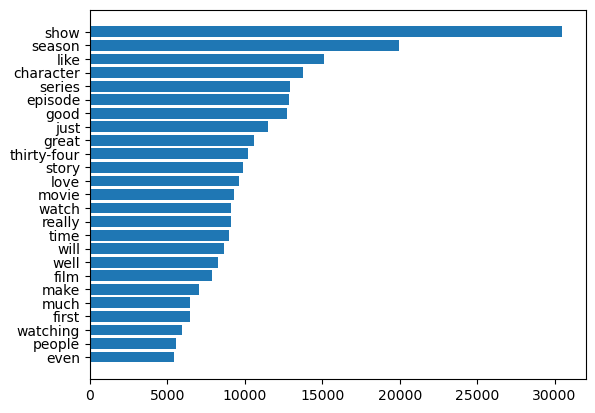

N-grams de todas las reviews

Bigramas más frecuentes


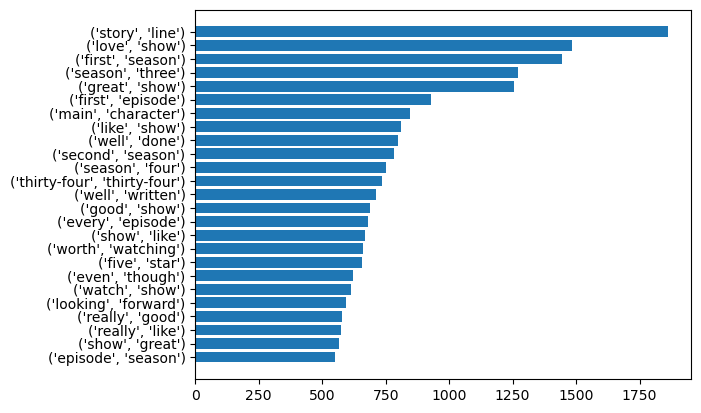

Trigramas más frecuentes


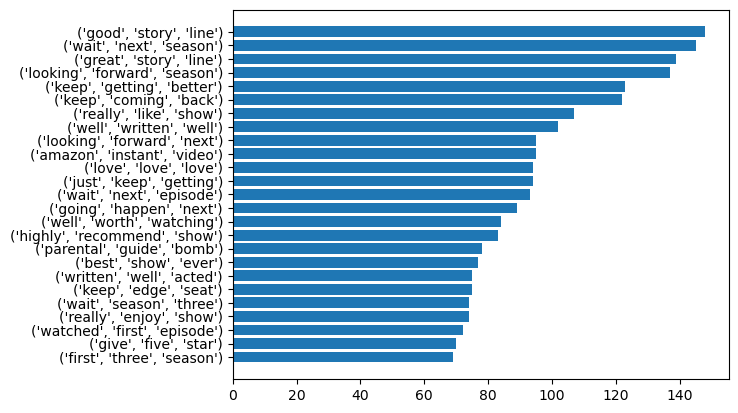

Nube de palabras


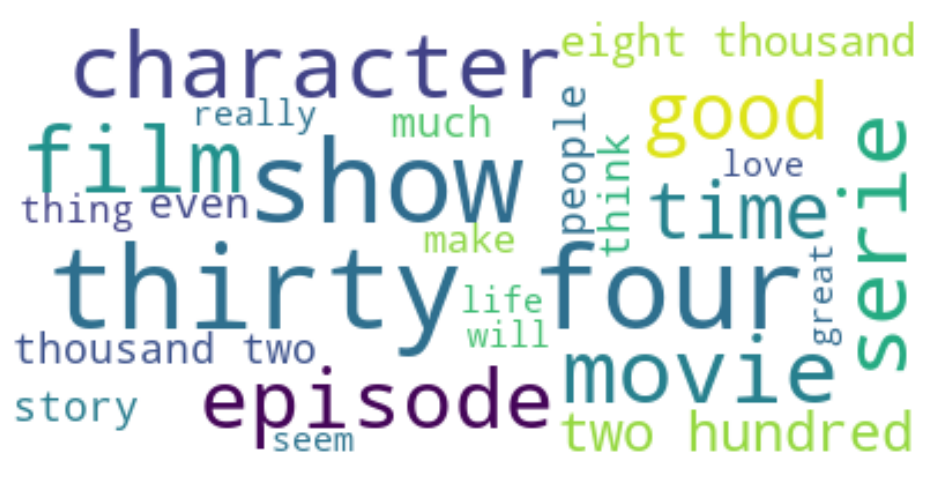

In [13]:
n_gram = n_grams()

print(f'{text[0]} mas frecuentes para todas las reviews')
crear_histo(n_gram[3])

print ('N-grams de todas las reviews\n')
for j in range(1,3):
    print(f'{text[j]} más frecuentes')
    crear_histo(n_gram[j])
    
print ('Nube de palabras')
plot_word_cloud(n_gram[0])

Palabras mas frecuentes para reviews con 5 estrellas


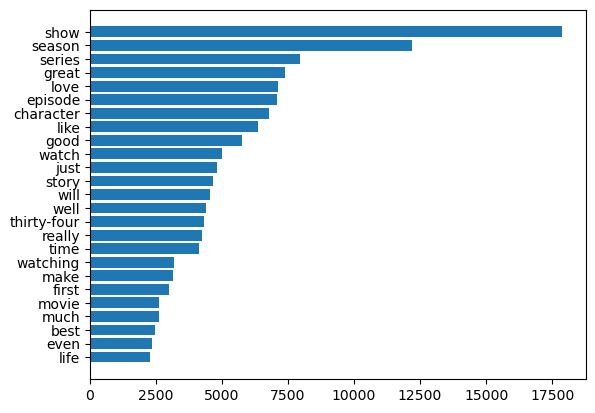

N-grams

Bigramas más frecuentes


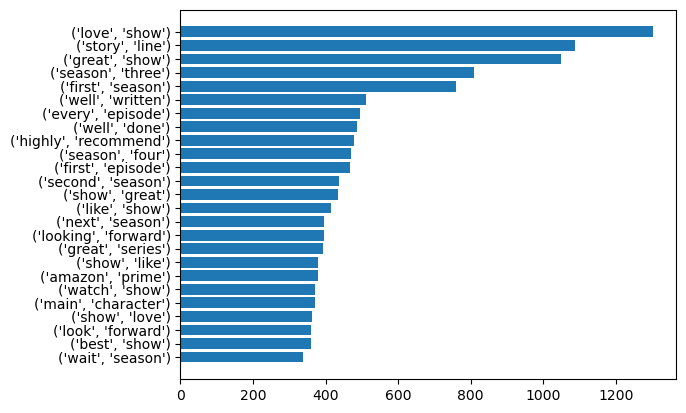

Trigramas más frecuentes


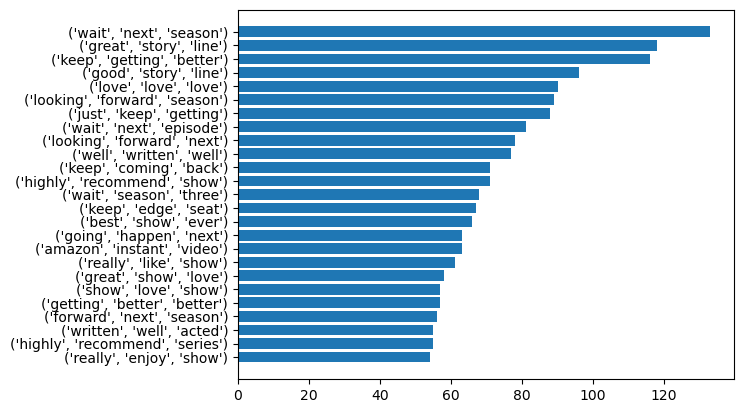

Nube de palabras


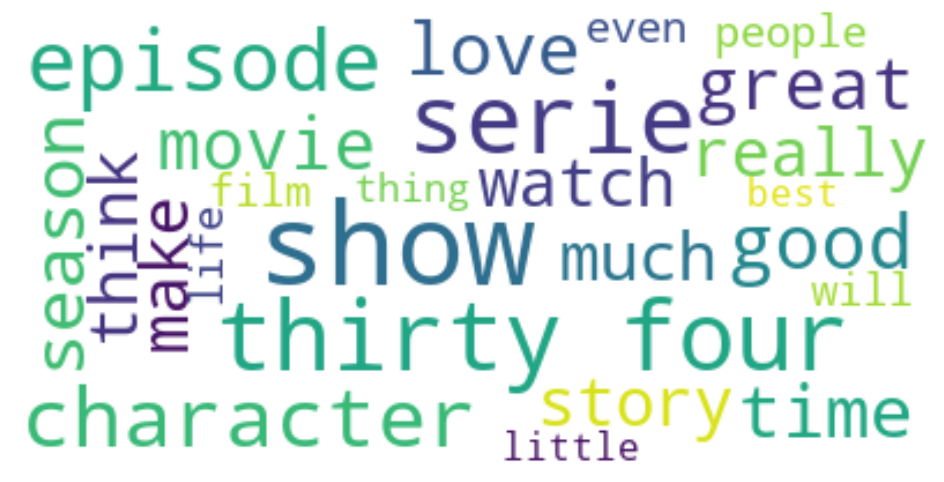

Palabras mas frecuentes para reviews con 4 estrellas


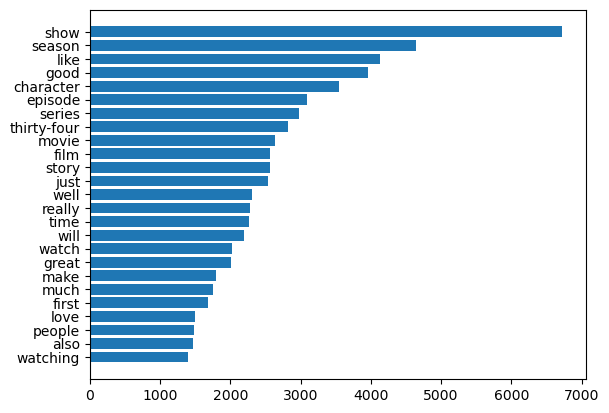

N-grams

Bigramas más frecuentes


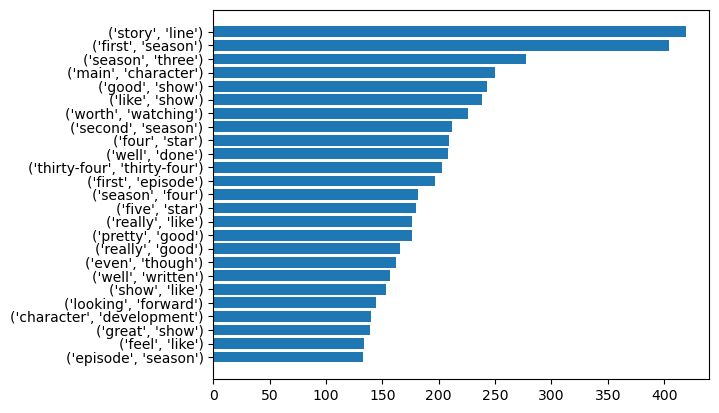

Trigramas más frecuentes


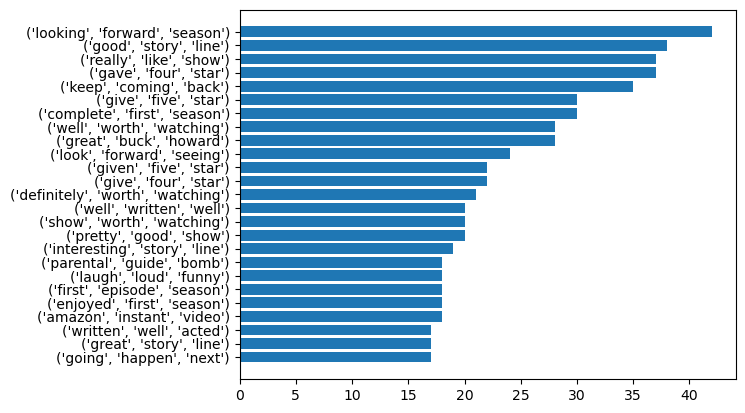

Nube de palabras


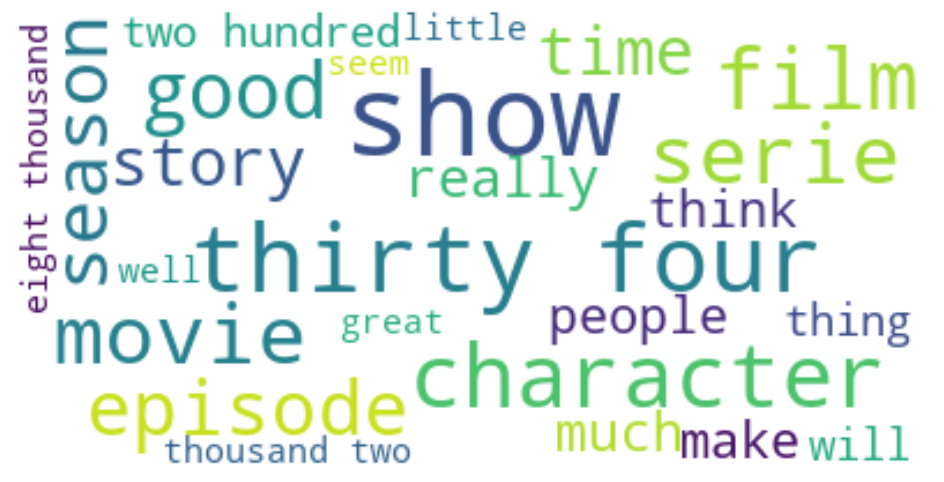

Palabras mas frecuentes para reviews con 3 estrellas


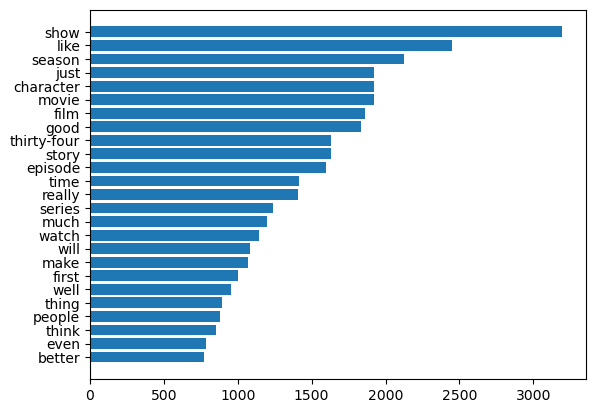

N-grams

Bigramas más frecuentes


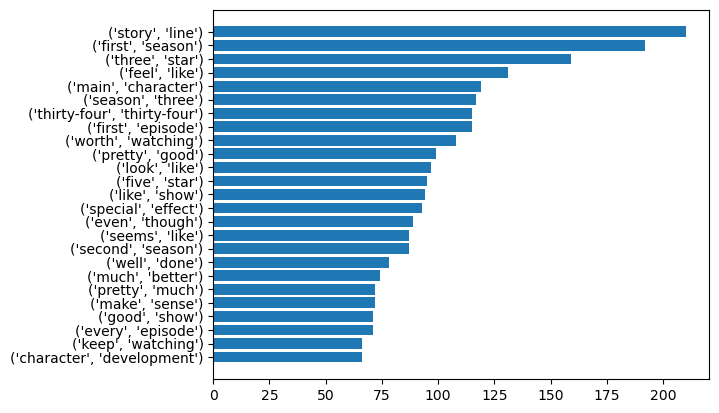

Trigramas más frecuentes


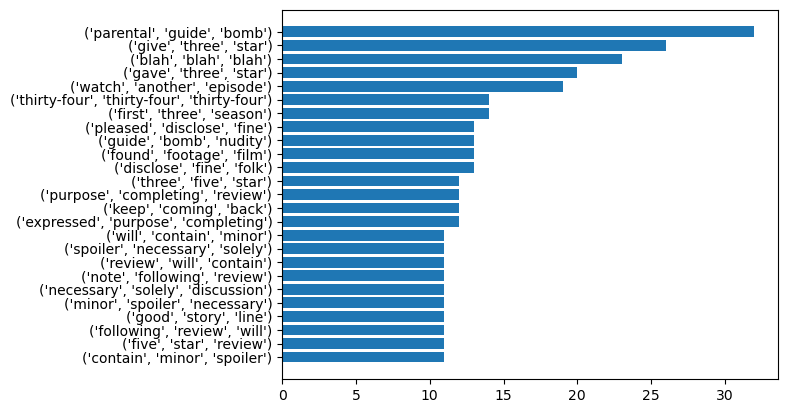

Nube de palabras


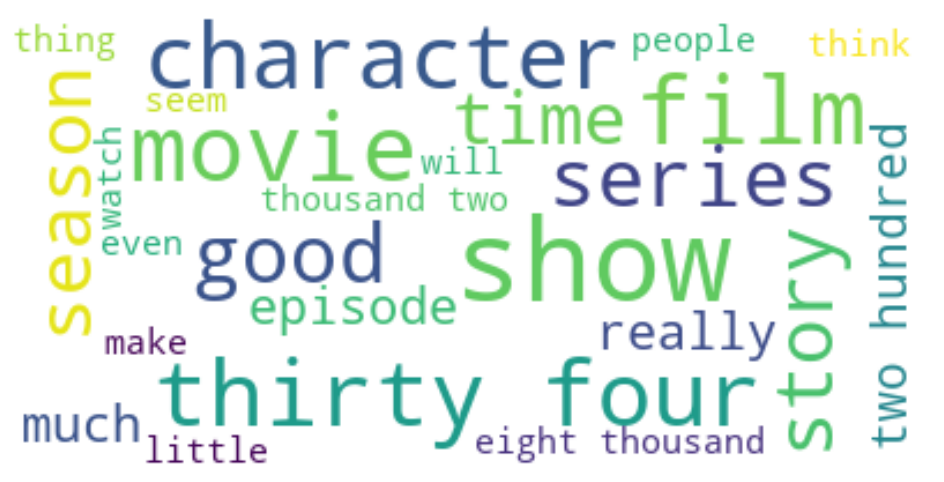

Palabras mas frecuentes para reviews con 2 estrellas


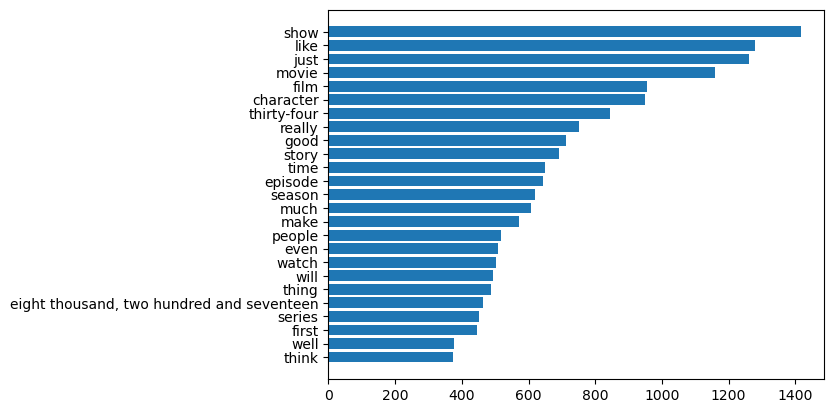

N-grams

Bigramas más frecuentes


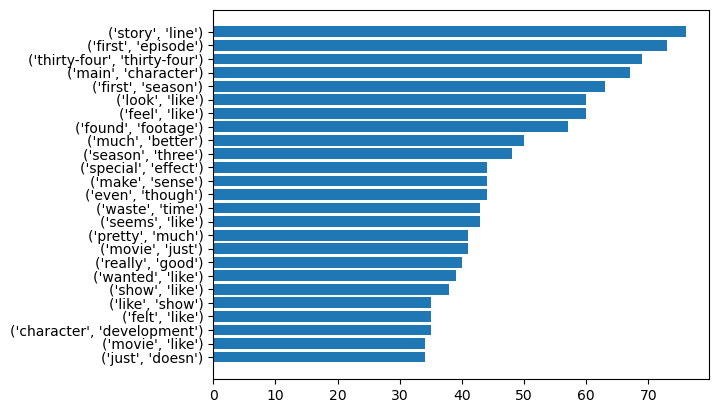

Trigramas más frecuentes


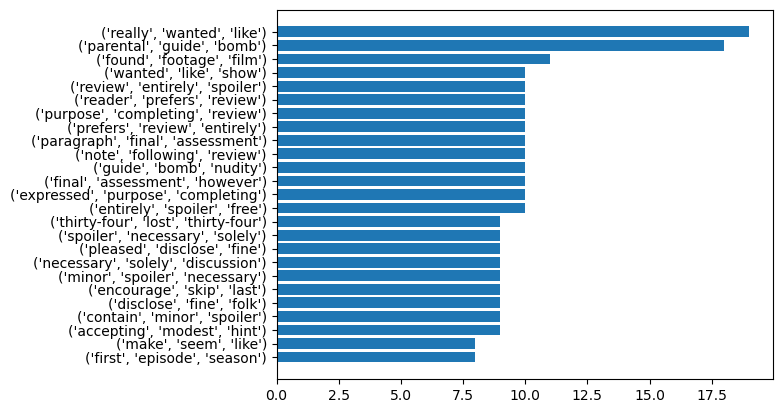

Nube de palabras


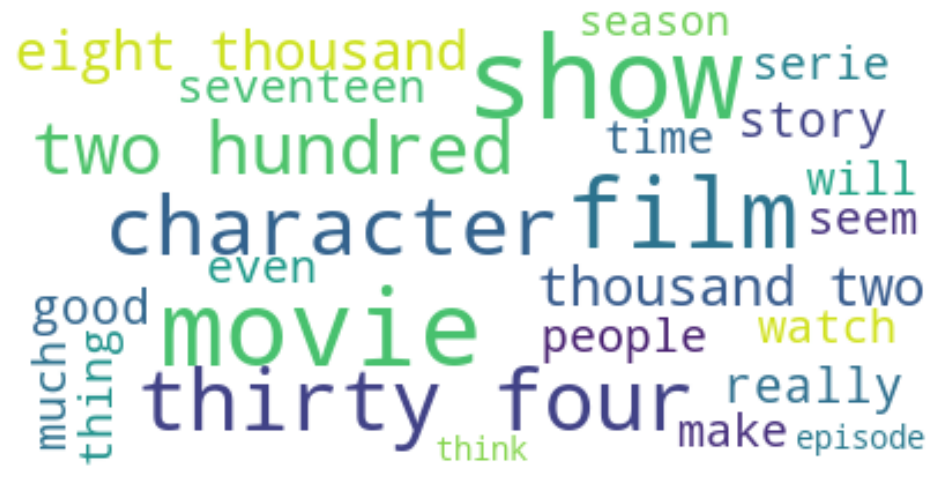

Palabras mas frecuentes para reviews con 1 estrellas


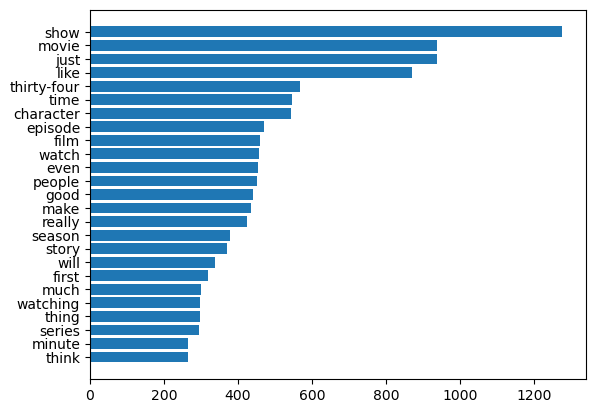

N-grams

Bigramas más frecuentes


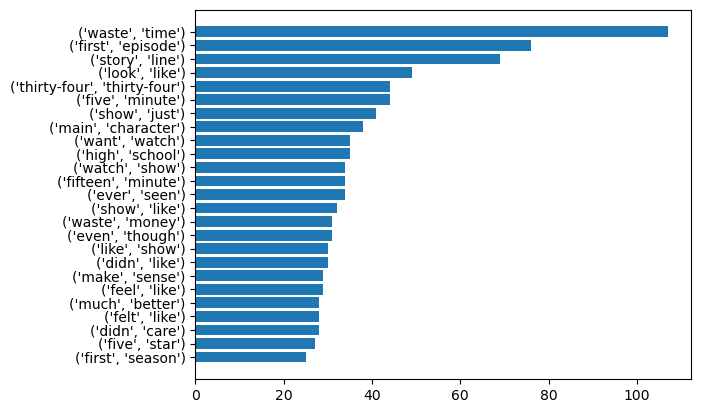

Trigramas más frecuentes


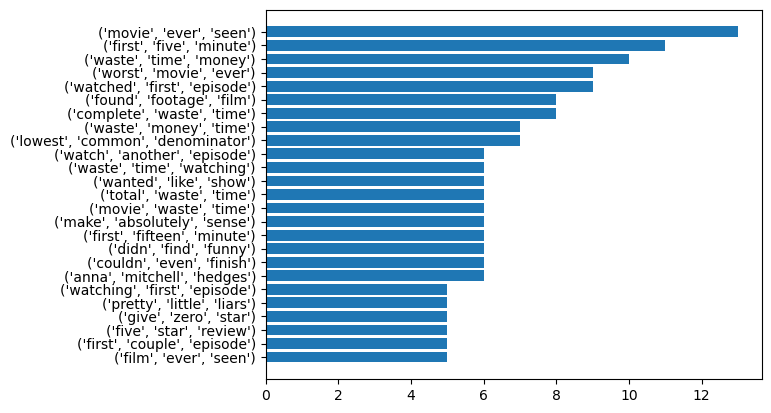

Nube de palabras


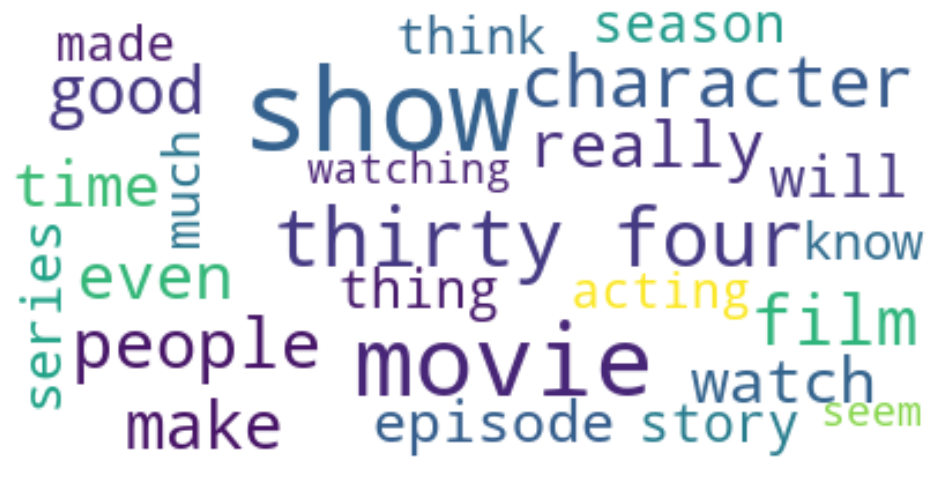

In [14]:
for i in range(5,0,-1):    
    n_gram = n_grams(i)
    
    print(f'{text[0]} mas frecuentes para reviews con {i} estrellas')
    crear_histo(n_gram[3])
    
    print (f'N-grams\n')
    for j in range(1,3):
        print(f'{text[j]} más frecuentes')
        crear_histo(n_gram[j])
        
    print ('Nube de palabras')
    plot_word_cloud(n_gram[0])

### Visualización en 2 dimensiones de algunos word embeddings calculados con Word2Vec y con FastText

Lo haremos con las reviews cinco estrellas.

In [15]:
sentences_N = ' '.join([WordNetLemmatizer().lemmatize(word) for word in n_grams(5)[0]])

Guardamos el corpus en un .txt para volver a instanciarlo para evitar problemas del método seek() con LineSentence:

In [16]:
with open('corpus.txt', 'w') as text_file:
    text_file.write(sentences_N)
corpus = LineSentence('corpus.txt')

In [17]:
def crear_cluster(model, keys):
    embedding_clusters = []
    word_clusters = []
    for word in keys:
        embeddings = []
        words = []
        for sim in model.wv.most_similar(word, topn=10):
            words.append(sim)
            embeddings.append(model.wv[sim[0]])
        embedding_clusters.append(embeddings)
        word_clusters.append(words)
    return embedding_clusters, word_clusters

def dim_2D(embedding_clusters):
    
    tsne_model_2d = TSNE(perplexity=15,
                         n_components=2,
                         init='pca',
                         n_iter=3500,
                         random_state=32)

    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape

    embeddings_2d = np.array(
        tsne_model_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
    return embeddings_2d

def print_sim_words(keys, word_clusters):
    for i, key in enumerate(keys):
        query = "Most similar to {}".format(key) 
        print(query)
        print("-"*len(query))
        for sim in word_clusters[i]:
            print(sim[0], "......", round(sim[1]*100, 2),"%")
        print("\n")
        
def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, c=[color], alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word[0], alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2), 
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.grid(True)
    plt.title('Representación en 2D de los embeddings de algunos clusters de palabras')
    plt.show()    

#### Word2Vec 

In [18]:
cbow_params = {
    'sg': 0,
    'vector_size': 300,
    'min_count': 5,
    'window': 5,
    'hs': 0,
    'negative': 20,
    'workers': 4
}

w2v_cbow = Word2Vec(**cbow_params)
w2v_cbow.build_vocab(corpus)
w2v_cbow.train(corpus, total_examples = w2v_cbow.corpus_count, epochs=10)
w2v_cbow.save('w2v_sg_d300_mc5_w5.pkl')
print('Vocabulario compuesto por {} palabras'.format(len(w2v_cbow.wv)))

Vocabulario compuesto por 9888 palabras


In [19]:
keys = ['problem', 'issue', 'perfectly', 'good', 'season', 'great', 'show']

In [20]:
embedding_clusters, word_clusters = crear_cluster(w2v_cbow, keys)
embeddings_2d = dim_2D(embedding_clusters)

In [21]:
print_sim_words(keys, word_clusters)   

Most similar to problem
-----------------------
issue ...... 72.69 %
deal ...... 65.49 %
medical ...... 62.53 %
dealing ...... 61.45 %
everyday ...... 61.2 %
solve ...... 59.45 %
normal ...... 58.98 %
solution ...... 58.76 %
hoarder ...... 58.41 %
case ...... 57.84 %


Most similar to issue
---------------------
problem ...... 72.69 %
deal ...... 69.93 %
professional ...... 69.38 %
circumstance ...... 69.15 %
environment ...... 68.52 %
society ...... 67.42 %
social ...... 66.5 %
situation ...... 66.38 %
dilemma ...... 66.35 %
profession ...... 64.63 %


Most similar to perfectly
-------------------------
brilliantly ...... 84.42 %
perfection ...... 81.21 %
superbly ...... 79.27 %
wonderfully ...... 78.35 %
phenomenal ...... 73.57 %
convincing ...... 73.17 %
beautifully ...... 73.11 %
marvelous ...... 71.91 %
excellently ...... 71.5 %
expertly ...... 71.28 %


Most similar to good
--------------------
great ...... 78.6 %
excellent ...... 70.04 %
cool ...... 58.77 %
notch ...... 56.9 %
l

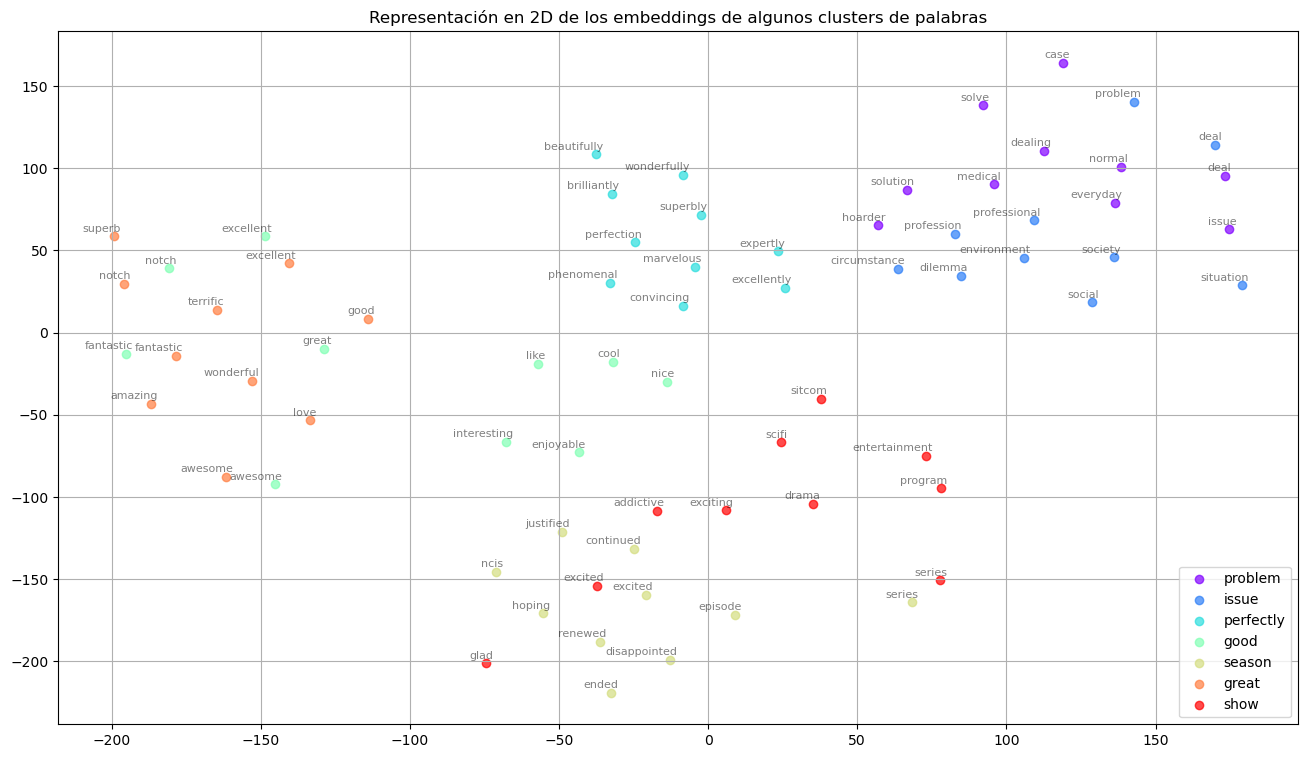

In [22]:
tsne_plot_similar_words(keys, embeddings_2d, word_clusters)

#### FastText

In [23]:
cbow_params = {
    'sg': 0,
    'vector_size': 300,
    'min_count': 5,
    'window': 5,
    'hs': 0,
    'negative': 20,
    'workers': 4,
    'min_n': 3,
    'max_n': 6
}

ft_cbow = FastText(**cbow_params)
ft_cbow.build_vocab(corpus)
ft_cbow.train(corpus, total_examples=ft_cbow.corpus_count, epochs=10)
ft_cbow.save('ft_cbow_d300_mc5_w5.pkl')
print('Vocabulario compuesto por {} palabras'.format(len(ft_cbow.wv)))

Vocabulario compuesto por 9888 palabras


In [24]:
embedding_clusters, word_clusters = crear_cluster(ft_cbow, keys)
embeddings_2d = dim_2D(embedding_clusters)

In [25]:
print_sim_words(keys, word_clusters)  

Most similar to problem
-----------------------
problematic ...... 80.71 %
primal ...... 74.27 %
probie ...... 73.45 %
prowess ...... 72.36 %
profit ...... 71.83 %
process ...... 71.78 %
issue ...... 71.68 %
tissue ...... 70.88 %
probst ...... 70.09 %
proud ...... 69.67 %


Most similar to issue
---------------------
tissue ...... 93.34 %
society ...... 80.57 %
societal ...... 79.86 %
professional ...... 75.45 %
ideal ...... 75.25 %
pursue ...... 74.85 %
facility ...... 74.38 %
inability ...... 73.72 %
consciousness ...... 73.03 %
responsibility ...... 72.98 %


Most similar to perfectly
-------------------------
perfect ...... 89.52 %
brilliantly ...... 86.95 %
imperfect ...... 83.9 %
incredibly ...... 79.2 %
superbly ...... 78.99 %
brilliant ...... 77.54 %
exceedingly ...... 77.49 %
masterfully ...... 76.76 %
flawlessly ...... 76.6 %
belly ...... 76.55 %


Most similar to good
--------------------
goode ...... 93.57 %
goody ...... 88.91 %
goof ...... 88.42 %
goodbye ...... 86.11 %
go

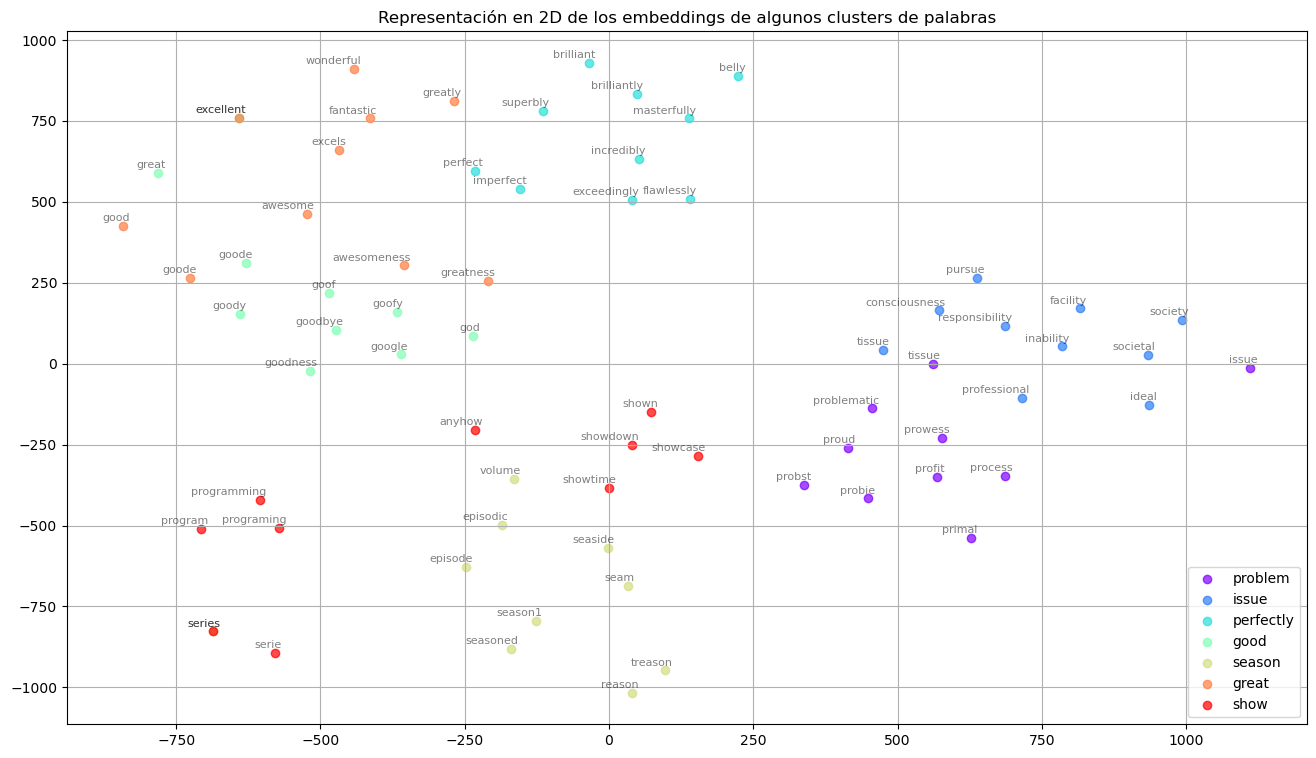

In [26]:
tsne_plot_similar_words(keys, embeddings_2d, word_clusters)